# Compare V gene and J gene use in our cohorts versus some example Emerson/Immunecode repertoires

Based on `vgene_usage_stats.ipynb`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from malid import config, io, helpers
from malid.datamodels import healthy_label, GeneLocus, TargetObsColumnEnum
import gc
import joblib
from kdict import kdict
import itertools
import genetools
from pathlib import Path
from slugify import slugify
import scanpy as sc
import anndata

In [2]:
def get_dirs(gene_locus: GeneLocus):
    output_dir = config.paths.model_interpretations_output_dir / gene_locus.name
    highres_output_dir = (
        config.paths.high_res_outputs_dir / "model_interpretations" / gene_locus.name
    )

    # Create directories - though these directories should already have been created by sequence model interpretations notebooks
    output_dir.mkdir(parents=True, exist_ok=True)
    highres_output_dir.mkdir(parents=True, exist_ok=True)

    return output_dir, highres_output_dir

In [3]:
# reimport (can resume here)
def import_v_gene_counts(gene_locus: GeneLocus):
    output_dir, highres_output_dir = get_dirs(gene_locus)

    specimen_v_gene_counts_df = pd.read_csv(
        highres_output_dir / "v_gene_counts_by_specimen.tsv.gz", sep="\t"
    )

    # subselect to test folds only (which also excludes global fold -1), and set index
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df[
        specimen_v_gene_counts_df["fold_label"] == "test"
    ]

    # confirm only one entry per specimen now
    assert not specimen_v_gene_counts_df_test_only["specimen_label"].duplicated().any()
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df_test_only.set_index(
        "specimen_label"
    ).drop(["fold_id", "fold_label"], axis=1)

    # fill na
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df_test_only.fillna(0)

    v_gene_cols = specimen_v_gene_counts_df_test_only.columns
    v_gene_cols = v_gene_cols[~v_gene_cols.isin(["disease"])]

    # get filtered subset of v_gene_cols, produced previously
    v_gene_cols_filtered = pd.read_csv(output_dir / "meaningful_v_genes.txt")[
        "v_gene"
    ].values
    assert all(vgene in v_gene_cols for vgene in v_gene_cols_filtered)  # sanity check

    return specimen_v_gene_counts_df_test_only, v_gene_cols, v_gene_cols_filtered

In [4]:
extra_specimen_metadata = helpers.get_all_specimen_info()
extra_specimen_metadata = extra_specimen_metadata[
    extra_specimen_metadata["in_training_set"]
].copy()
extra_specimen_metadata

,participant_label,specimen_label,disease,specimen_time_point,participant_description,cohort,study_name,available_gene_loci,disease_subtype,age,...,cmv,disease_severity,specimen_time_point_days,cov2_seropositivity,survived_filters,is_peak,in_training_set,past_exposure,disease.separate_past_exposures,test_fold_id
0,BFI-0007450,M369-S001,Covid19,9 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),73.0,...,NaN,ICU,9.0,Not exposed,True,True,True,False,Covid19,0.0
5,BFI-0007453,M371-S004,Covid19,15 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),64.0,...,NaN,ICU,15.0,Not exposed,True,True,True,False,Covid19,0.0
9,BFI-0007455,M371-S031,Covid19,12 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),36.0,...,NaN,ICU,12.0,Not exposed,True,True,True,False,Covid19,2.0
13,BFI-0007480,M371-S015,Covid19,14 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),40.0,...,NaN,ICU,14.0,Not exposed,True,True,True,False,Covid19,0.0
14,BFI-0007481,M371-S005,Covid19,32 days,COVID-19 project,Boydlab,Covid19-buffycoat,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Covid19 - Sero-positive (ICU),66.0,...,NaN,ICU,32.0,Not exposed,True,True,True,False,Covid19,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,BFI-0010060,M456-S001,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,51.0,...,NaN,NaN,NaN,Not exposed,True,True,True,False,Lupus,2.0
816,BFI-0010061,M456-S002,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,34.0,...,NaN,NaN,NaN,Not exposed,True,True,True,False,Lupus,2.0
817,BFI-0010065,M456-S006,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,46.0,...,NaN,NaN,NaN,Not exposed,True,True,True,False,Lupus,2.0
818,BFI-0010067,M456-S008,Lupus,NaN,SLE Patient,Boydlab,New Lupus Paxgene,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",SLE Patient,49.0,...,NaN,NaN,NaN,Not exposed,True,True,True,False,Lupus,0.0


In [5]:
(
    specimen_v_gene_counts_df_test_only,
    v_gene_cols,
    v_gene_cols_filtered,
) = import_v_gene_counts(gene_locus=GeneLocus.TCR)

# Get V gene usage proportions per specimen
v_gene_usage_proportions_by_specimen = pd.concat(
    [
        genetools.stats.normalize_rows(
            specimen_v_gene_counts_df_test_only[v_gene_cols]
        ),
        specimen_v_gene_counts_df_test_only["disease"],
    ],
    axis=1,
)

v_gene_usage_proportions_by_specimen_annot = genetools.helpers.merge_into_left(
    v_gene_usage_proportions_by_specimen[v_gene_cols],
    extra_specimen_metadata.set_index("specimen_label"),
)


# drop specimens with group N/A
v_gene_usage_proportions_by_specimen_annot = (
    v_gene_usage_proportions_by_specimen_annot.dropna(subset=["study_name"])
)

v_gene_usage_proportions_by_specimen_annot_melt = pd.melt(
    v_gene_usage_proportions_by_specimen_annot,
    id_vars=["disease", "study_name"],
    value_vars=v_gene_cols,
    var_name="V gene",
    value_name="Proportion",
)
v_gene_usage_proportions_by_specimen_annot_melt

,disease,study_name,V gene,Proportion
0,HIV,HIV,TRBV20-1,0.148730
1,HIV,HIV,TRBV20-1,0.110739
2,HIV,HIV,TRBV20-1,0.108388
3,HIV,HIV,TRBV20-1,0.128455
4,HIV,HIV,TRBV20-1,0.123805
...,...,...,...,...
23179,Healthy/Background,Healthy-StanfordBloodCenter,TRBV29/OR9-2,0.000000
23180,Healthy/Background,Healthy-StanfordBloodCenter,TRBV29/OR9-2,0.000000
23181,Healthy/Background,Healthy-StanfordBloodCenter,TRBV29/OR9-2,0.000000
23182,Healthy/Background,Healthy-StanfordBloodCenter,TRBV29/OR9-2,0.000000


In [6]:
def make_counts(fname, disease, study_name):
    external_df = pd.read_parquet(fname)
    counts = (
        external_df["v_gene"]
        .cat.remove_unused_categories()
        .value_counts(normalize=True)
    )
    return (
        counts.rename_axis(index="V gene")
        .reset_index(name="Proportion")
        .assign(disease=disease, study_name=study_name)
    )

In [7]:
# TODO: switch this to exactly the same ones used in external cohort evaluation
emerson_fnames = list(config.paths.external_processed_data.glob("P00*.parquet")) + list(
    config.paths.external_processed_data.glob("Keck*.parquet")
)
np.random.shuffle(emerson_fnames)
immunecode_fnames = list(
    config.paths.external_processed_data.glob("ImmuneCode*.parquet")
)
len(emerson_fnames), len(immunecode_fnames)

(786, 93)

In [8]:
external_counts = []

for fname in immunecode_fnames[: len(immunecode_fnames)]:
    print(fname)
    external_counts.append(
        make_counts(fname=fname, disease="Covid19", study_name="Immunecode")
    )

for fname in emerson_fnames[: len(immunecode_fnames)]:
    print(fname)
    external_counts.append(
        make_counts(fname=fname, disease="Healthy/Background", study_name="Emerson")
    )

/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/external_cohorts_part_tables/ImmuneCode-0000051.parquet
/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/external_cohorts_part_tables/ImmuneCode-0000066.parquet
/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/external_cohorts_part_tables/ImmuneCode-ADIRP0001958.parquet
/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/external_cohorts_part_tables/ImmuneCode-0000458.parquet
/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/external_cohorts_part_tables/ImmuneCode-0000135.parquet
/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/external_cohorts_part_tables/ImmuneCode-588140.parquet
/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/external_cohorts_part_tables/ImmuneCode-321977.parquet
/users/maximz/code/boyd-immune-repertoire-classification/da

In [9]:
v_gene_usage_proportions_by_specimen_annot_melt_combined = pd.concat(
    [v_gene_usage_proportions_by_specimen_annot_melt] + external_counts,
    axis=0,
)
v_gene_usage_proportions_by_specimen_annot_melt_combined

,disease,study_name,V gene,Proportion
0,HIV,HIV,TRBV20-1,0.148730
1,HIV,HIV,TRBV20-1,0.110739
2,HIV,HIV,TRBV20-1,0.108388
3,HIV,HIV,TRBV20-1,0.128455
4,HIV,HIV,TRBV20-1,0.123805
...,...,...,...,...
48,Healthy/Background,Emerson,TRBV6-9,0.000157
49,Healthy/Background,Emerson,TRBV5-7,0.000083
50,Healthy/Background,Emerson,TRBV26,0.000004
51,Healthy/Background,Emerson,TRBV20/OR9-2,0.000004


In [10]:
group_color_palette = {
    group: color
    for group, color in zip(
        v_gene_usage_proportions_by_specimen_annot_melt_combined["study_name"].unique(),
        sc.plotting.palettes.default_20,
    )
}


def plot_per_disease(
    v_gene_usage_proportions_by_specimen_annot_melt_combined: pd.DataFrame,
    disease: str,
    filtered=False,
):
    height = 6 if filtered else 12
    selected_v_gene_order = pd.Series(v_gene_cols_filtered if filtered else v_gene_cols)

    selected_v_gene_order = pd.Series(
        sorted(
            v_gene_usage_proportions_by_specimen_annot_melt_combined["V gene"].unique()
        )
    )

    v_gene_usage_proportions_by_specimen_annot_melt_this_disease = (
        v_gene_usage_proportions_by_specimen_annot_melt_combined[
            v_gene_usage_proportions_by_specimen_annot_melt_combined["disease"]
            == disease
        ]
    )
    # Sort for consistent group order
    groups_this_disease = sorted(
        v_gene_usage_proportions_by_specimen_annot_melt_this_disease[
            "study_name"
        ].unique()
    )
    if len(groups_this_disease) == 0:
        print(f"No study_name group info for {disease} - skipping")
        return None

    # Divide the disease plot into subplots by group
    fig, axarr = plt.subplots(
        nrows=1,
        ncols=len(groups_this_disease),
        figsize=(3 * len(groups_this_disease), height),
        sharex=True,  # Make xlims consistent for better readability
        sharey=False,  # Repeat the V gene in each axis for better readability
    )
    for (group, ax) in zip(groups_this_disease, axarr):
        data = v_gene_usage_proportions_by_specimen_annot_melt_this_disease[
            v_gene_usage_proportions_by_specimen_annot_melt_this_disease["study_name"]
            == group
        ]
        sns.barplot(
            # Switch to friendly V gene names
            data=data.assign(
                **{"V gene": data["V gene"].replace(helpers.v_gene_friendly_names)}
            ),
            x="Proportion",
            y="V gene",
            # reference V gene order, possibly filtered down
            order=sorted(selected_v_gene_order.replace(helpers.v_gene_friendly_names)),
            ax=ax,
            color=group_color_palette[group],
            # Compute 95% confidence intervals around a sample mean by bootstrapping:
            # sampling distribution of mean generated by repeated sampling and recording mean each time.
            # the standard error is basically the standard deviation of many sample means
            # we plot mean +/- 1.96*standard error. gives you average value +/- X at the 95% confidence level.
            ci=95,
            # ci="sd", # instead draw the standard deviation of the observations, instead of bootstrapping to get 95% confidence intervals
            # capsize=.025
        )

        ax.set_title(f"{group}", fontweight="bold")
        ax.set_xlabel("Proportion of specimen\n(mean +/- 95% confidence interval)")
        ax.set_ylabel(None)
        sns.despine(ax=ax)

    axarr[0].set_ylabel("V gene")
    fig.suptitle(disease, fontsize="x-large", fontweight="bold")
    plt.tight_layout()
    return fig

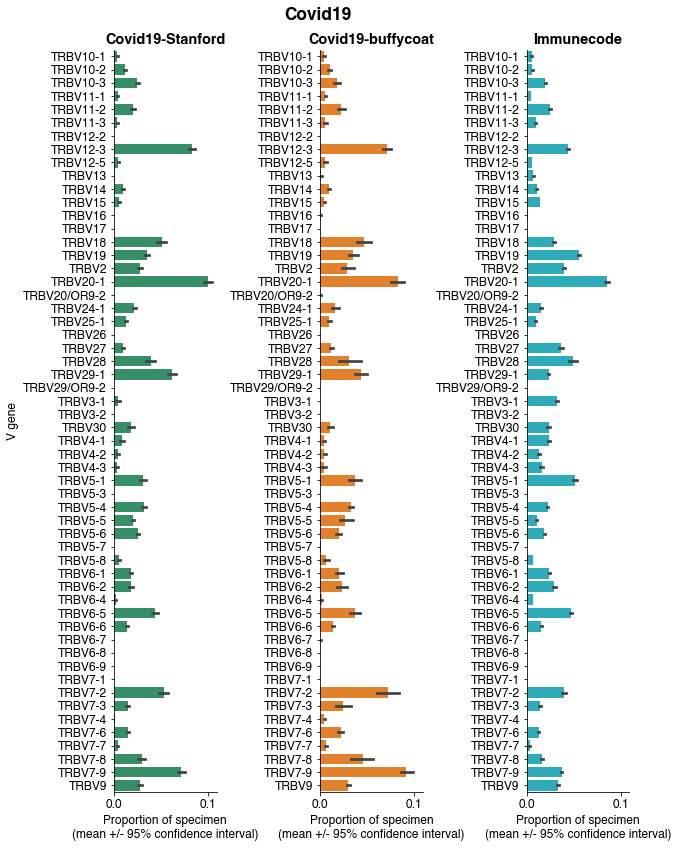

In [11]:
# Plot for all V genes
fig = plot_per_disease(
    v_gene_usage_proportions_by_specimen_annot_melt_combined=v_gene_usage_proportions_by_specimen_annot_melt_combined,
    disease="Covid19",
    filtered=False,
)

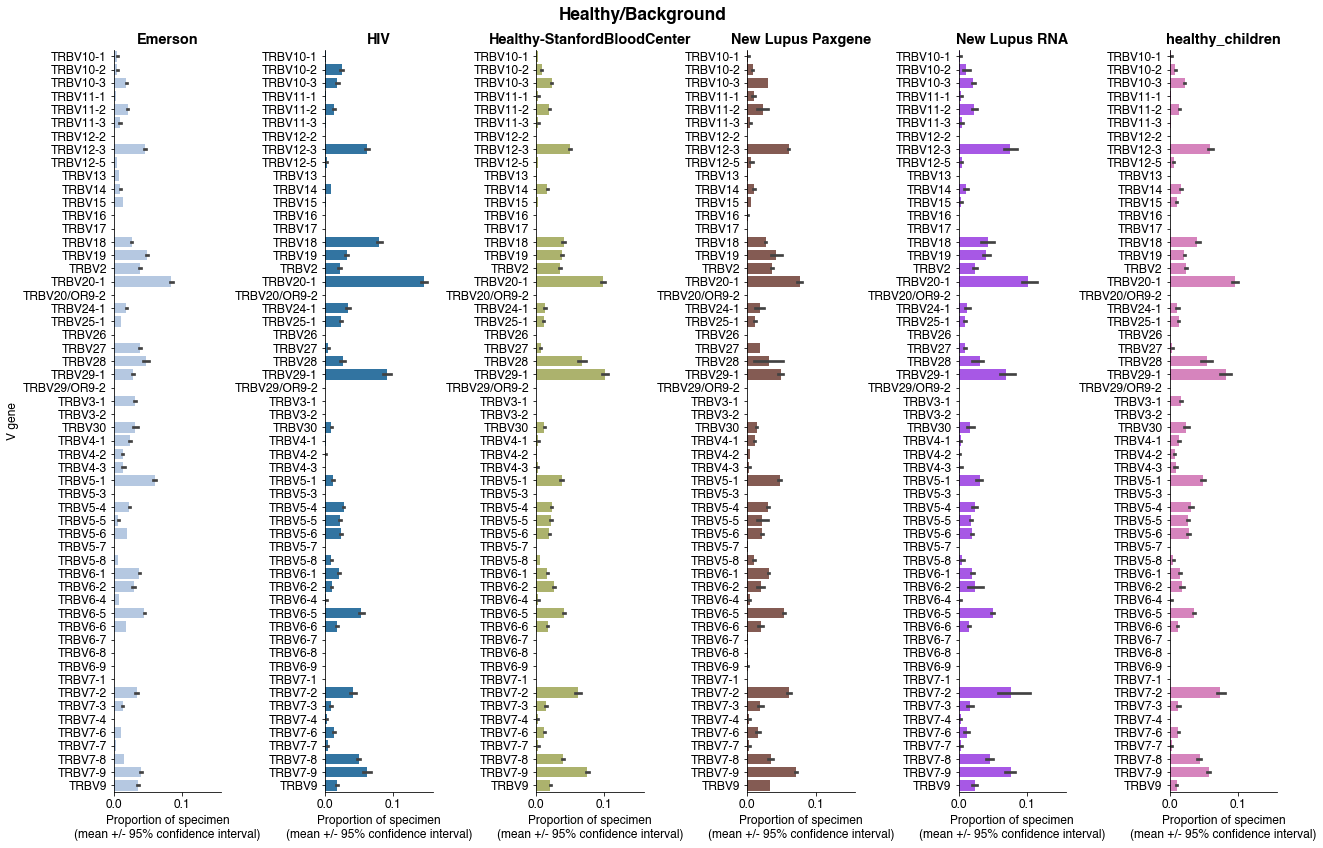

In [12]:
# Plot for all V genes
fig = plot_per_disease(
    v_gene_usage_proportions_by_specimen_annot_melt_combined=v_gene_usage_proportions_by_specimen_annot_melt_combined,
    disease="Healthy/Background",
    filtered=False,
)

# Embed on UMAP and see where it lands?

In [13]:
ec_combined = pd.concat(
    [
        ec.pivot(index=["study_name", "disease"], columns="V gene", values="Proportion")
        for ec in external_counts
    ],
    axis=0,
)
ec_combined

V gene                         TRBV10-1  TRBV10-2  TRBV10-3  TRBV11-1  \
study_name disease                                                      
Immunecode Covid19             0.007229  0.008804  0.014055  0.003640   
           Covid19             0.006751  0.007466  0.019281  0.003938   
           Covid19             0.008033  0.009409  0.019784  0.000615   
           Covid19             0.005823  0.004637  0.011323  0.003882   
           Covid19             0.003913  0.004894  0.021006  0.006312   
...                                 ...       ...       ...       ...   
Emerson    Healthy/Background  0.003808  0.003424  0.020434  0.004803   
           Healthy/Background  0.008929  0.008266  0.020494  0.003588   
           Healthy/Background  0.001518  0.001415  0.013226  0.005003   
           Healthy/Background  0.003675  0.003830  0.015929  0.003306   
           Healthy/Background  0.000923  0.002248  0.020816  0.004073   

V gene                         TRBV11-2  TRBV11-3  TRBV12-2  TRBV12-3  \
study_name disease                                                      
Immunecode Covid19             0.029325  0.019119  0.001043  0.053256   
           Covid19             0.030852  0.007922  0.000958  0.044902   
           Covid19             0.031316  0.009462  0.000893  0.041711   
           Covid19             0.019843  0.007441  0.001294  0.043244   
           Covid19             0.022799  0.016415  0.000533  0.041153   
...                                 ...       ...       ...       ...   
Emerson    Healthy/Background  0.022691  0.020205  0.000596  0.053742   
           Healthy/Background  0.022362  0.016808  0.000726  0.050183   
           Healthy/Background  0.010305  0.017792  0.000690  0.049338   
           Healthy/Background  0.021933  0.006488  0.000574  0.044103   
           Healthy/Background  0.020369  0.006399  0.000497  0.050631   

V gene                         TRBV12-5    TRBV13  ...   TRBV7-4   TRBV7-6  \
study_name disease                                 ...                       
Immunecode Covid19             0.007819  0.007919  ...  0.000316  0.011372   
           Covid19             0.005565  0.006021  ...  0.000350  0.013229   
           Covid19             0.003011  0.008443  ...  0.000212  0.013531   
           Covid19             0.004853  0.004421  ...       NaN  0.009166   
           Covid19             0.005003  0.007463  ...  0.000097  0.011073   
...                                 ...       ...  ...       ...       ...   
Emerson    Healthy/Background  0.008385  0.008907  ...  0.000123  0.011023   
           Healthy/Background  0.007056  0.005362  ...  0.000212  0.011591   
           Healthy/Background  0.006670  0.008183  ...  0.000219  0.013381   
           Healthy/Background  0.002247  0.010655  ...  0.000197  0.009908   
           Healthy/Background  0.004942  0.008221  ...  0.000174  0.010944   

V gene                          TRBV7-7   TRBV7-8   TRBV7-9     TRBV9  \
study_name disease                                                      
Immunecode Covid19             0.003596  0.020046  0.037705  0.033209   
           Covid19             0.002935  0.019190  0.039079  0.020969   
           Covid19             0.002779  0.021802  0.038178  0.031660   
           Covid19             0.003020  0.014127  0.036666  0.028254   
           Covid19             0.002798  0.017130  0.036380  0.034042   
...                                 ...       ...       ...       ...   
Emerson    Healthy/Background  0.002987  0.013607  0.036894  0.045875   
           Healthy/Background  0.003838  0.013195  0.040376  0.029235   
           Healthy/Background  0.004267  0.017567  0.043939  0.038269   
           Healthy/Background  0.002953  0.012451  0.036147  0.036590   
           Healthy/Background  0.003667  0.016073  0.038830  0.031210   

V gene                          TRBV7-1  TRBV20/OR9-2    TRBV26  TRBV29/OR9-2  
study_name disease                                     

In [14]:
ec_data = ec_combined.reset_index(drop=True)
ec_obs = ec_combined.index.to_frame().reset_index(drop=True)

In [15]:
ec_data_c = pd.concat(
    [ec_data, v_gene_usage_proportions_by_specimen_annot[v_gene_cols]], axis=0
)
ec_obs_c = pd.concat(
    [ec_obs, v_gene_usage_proportions_by_specimen_annot[["study_name", "disease"]]],
    axis=0,
)

In [16]:
ec_data_c.isna().any()

TRBV10-1        False
TRBV10-2        False
TRBV10-3        False
TRBV11-1        False
TRBV11-2        False
TRBV11-3        False
TRBV12-2        False
TRBV12-3        False
TRBV12-5        False
TRBV13          False
TRBV14          False
TRBV15          False
TRBV16           True
TRBV17           True
TRBV18          False
TRBV19          False
TRBV2           False
TRBV20-1        False
TRBV24-1        False
TRBV25-1        False
TRBV27          False
TRBV28          False
TRBV29-1        False
TRBV3-1         False
TRBV30          False
TRBV4-1         False
TRBV4-2         False
TRBV4-3          True
TRBV5-1         False
TRBV5-3         False
TRBV5-4         False
TRBV5-5         False
TRBV5-6         False
TRBV5-7          True
TRBV5-8          True
TRBV6-1         False
TRBV6-2         False
TRBV6-4         False
TRBV6-5         False
TRBV6-6         False
TRBV6-7          True
TRBV6-8          True
TRBV6-9          True
TRBV7-2         False
TRBV7-3         False
TRBV7-4   

In [17]:
ec_data_c = ec_data_c.dropna(axis=1)

In [27]:
# TODO: switch to V genes from model1's choices?
meaningful_v_genes = pd.read_csv(
    config.paths.model_interpretations_output_dir
    / GeneLocus.TCR.name
    / "meaningful_v_genes.txt",
    sep="\t",
)["v_gene"].tolist()
meaningful_v_genes

['TRBV10-2',
 'TRBV10-3',
 'TRBV11-2',
 'TRBV12-3',
 'TRBV14',
 'TRBV18',
 'TRBV19',
 'TRBV2',
 'TRBV20-1',
 'TRBV24-1',
 'TRBV25-1',
 'TRBV28',
 'TRBV29-1',
 'TRBV30',
 'TRBV5-1',
 'TRBV5-4',
 'TRBV5-5',
 'TRBV5-6',
 'TRBV6-1',
 'TRBV6-2',
 'TRBV6-5',
 'TRBV6-6',
 'TRBV7-2',
 'TRBV7-3',
 'TRBV7-6',
 'TRBV7-8',
 'TRBV7-9',
 'TRBV9']

In [54]:
adata_subset = anndata.AnnData(
    ec_data_c[[v for v in meaningful_v_genes if v in ec_data_c.columns]], obs=ec_obs_c
)
adata_subset

2023-01-05 14:40:45,900 - py.warnings - WARNING - /tmp/ipykernel_26605/2016513.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_subset = anndata.AnnData(



AnnData object with n_obs × n_vars = 600 × 28
    obs: 'study_name', 'disease'

In [55]:
adata_subset.shape

((600, 28), (600, 42))

In [56]:
adata_subset.obs["label"] = (
    adata_subset.obs["disease"] + " - " + adata_subset.obs["study_name"]
)

In [57]:
# make a new label like Covid-19 (Mal-ID), Covid-19 (Adaptive), etc.
adata_subset.obs.drop_duplicates()

,study_name,disease,label
0,Immunecode,Covid19,Covid19 - Immunecode
93,Emerson,Healthy/Background,Healthy/Background - Emerson
M111-S003,HIV,HIV,HIV - HIV
M124-S001,HIV,Healthy/Background,Healthy/Background - HIV
M369-S001,Covid19-buffycoat,Covid19,Covid19 - Covid19-buffycoat
M418-S010,Covid19-Stanford,Covid19,Covid19 - Covid19-Stanford
M447-S002,Lupus Pediatric,Lupus,Lupus - Lupus Pediatric
M454-S015,New Lupus RNA,Lupus,Lupus - New Lupus RNA
M454-S030,New Lupus RNA,Healthy/Background,Healthy/Background - New Lupus RNA
M456-S007,New Lupus Paxgene,Healthy/Background,Healthy/Background - New Lupus Paxgene


In [58]:
adata_subset.obs["label2"] = (
    adata_subset.obs["disease"].astype(str)
    + " - "
    + adata_subset.obs["study_name"]
    .map({"Immunecode": "Adaptive", "Emerson": "Adaptive"})
    .fillna("Mal-ID")
)
adata_subset.obs["label2"].value_counts()

Healthy/Background - Mal-ID      194
HIV - Mal-ID                      98
Covid19 - Adaptive                93
Healthy/Background - Adaptive     93
Lupus - Mal-ID                    64
Covid19 - Mal-ID                  58
Name: label2, dtype: int64

In [59]:
adata_subset.obs.drop_duplicates()

,study_name,disease,label,label2
0,Immunecode,Covid19,Covid19 - Immunecode,Covid19 - Adaptive
93,Emerson,Healthy/Background,Healthy/Background - Emerson,Healthy/Background - Adaptive
M111-S003,HIV,HIV,HIV - HIV,HIV - Mal-ID
M124-S001,HIV,Healthy/Background,Healthy/Background - HIV,Healthy/Background - Mal-ID
M369-S001,Covid19-buffycoat,Covid19,Covid19 - Covid19-buffycoat,Covid19 - Mal-ID
M418-S010,Covid19-Stanford,Covid19,Covid19 - Covid19-Stanford,Covid19 - Mal-ID
M447-S002,Lupus Pediatric,Lupus,Lupus - Lupus Pediatric,Lupus - Mal-ID
M454-S015,New Lupus RNA,Lupus,Lupus - New Lupus RNA,Lupus - Mal-ID
M454-S030,New Lupus RNA,Healthy/Background,Healthy/Background - New Lupus RNA,Healthy/Background - Mal-ID
M456-S007,New Lupus Paxgene,Healthy/Background,Healthy/Background - New Lupus Paxgene,Healthy/Background - Mal-ID


In [61]:
sc.pp.scale(adata_subset)

In [62]:
sc.tl.pca(adata_subset)

In [63]:
sc.pp.neighbors(adata_subset)
sc.tl.umap(adata_subset)

2023-01-05 14:40:48,613 - anndata - INFO - ... storing 'study_name' as categorical
2023-01-05 14:40:48,618 - anndata - INFO - ... storing 'disease' as categorical
2023-01-05 14:40:48,621 - anndata - INFO - ... storing 'label' as categorical
2023-01-05 14:40:48,625 - anndata - INFO - ... storing 'label2' as categorical


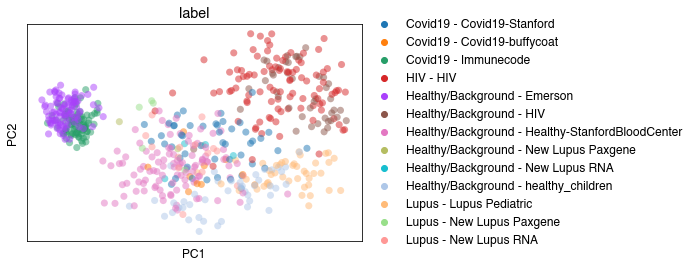

In [64]:
sc.pl.pca(adata_subset, color="label", alpha=0.5)

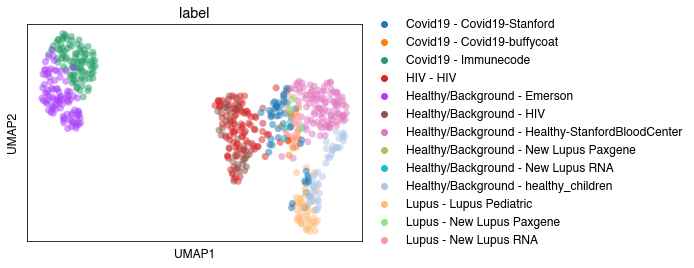

In [65]:
sc.pl.umap(adata_subset, color="label", alpha=0.5)

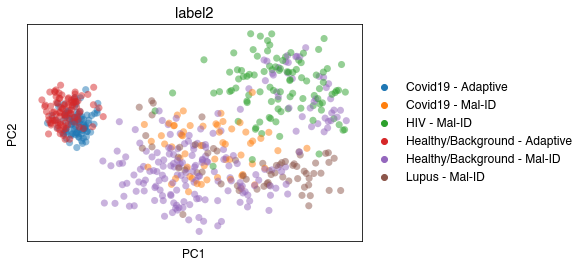

In [66]:
sc.pl.pca(adata_subset, color="label2", alpha=0.5)

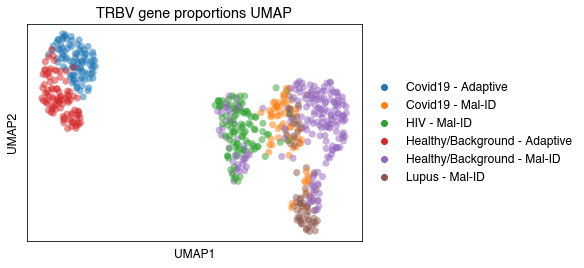

In [72]:
fig_umap = sc.pl.umap(
    adata_subset,
    color="label2",
    alpha=0.5,
    return_fig=True,
    title="TRBV gene proportions UMAP",
)
genetools.plots.savefig(
    fig_umap,
    config.paths.model_interpretations_output_dir
    / GeneLocus.TCR.name
    / f"v_gene_proportions_by_specimen.adaptive_vs_malid.png",
    dpi=300,
)

In [68]:
# TODO: add the other external cohorts that are more similar to ours